# WEB SCRAPING

## Парсинг музыкальной библиотеки [Premium beat](https://www.premiumbeat.com/)

### Идея:
### - собрать описание всех треков в библиотеке,
### - построить модель для предсказания популярности треков.

In [62]:
import requests
from fake_useragent import UserAgent
import lxml
from bs4 import BeautifulSoup

import numpy as np
import pandas as pd
import time

from IPython.display import clear_output

import csv

## 1. Изучение структуры страниц сайта

In [2]:
fake_agent = UserAgent().ie

In [3]:
start_url = 'https://www.premiumbeat.com/royalty-free-music?page=1&sort=popular'

In [4]:
response = requests.get(start_url, headers={'User-Agent': fake_agent})
response

<Response [200]>

In [5]:
raw_content = response.content

In [6]:
html_content = BeautifulSoup(raw_content,'lxml')

___Содержимое первой страницы при выборе сортировки треков по популярности___

In [7]:
html_content

<!DOCTYPE html>
<html data-reactroot="" lang="en"><head><link as="style" href="/dist/main.fd78cc0fa01b7cd73890.css" rel="preload"/><link as="font" crossorigin="anonymous" href="/dist/walsheim-thin-8c0a41c4.woff2" rel="preload" type="font/woff2"/><link as="font" crossorigin="anonymous" href="/dist/walsheim-regular-947c1229.woff2" rel="preload" type="font/woff2"/><link as="font" crossorigin="anonymous" href="/dist/walsheim-bold-59916708.woff2" rel="preload" type="font/woff2"/><link href="https://bam.nr-data.net" rel="preconnect"/><link href="https://js-agent.newrelic.com" rel="preconnect"/><title data-react-helmet="true">Royalty Free Music - Find Your Perfect Track - PremiumBeat</title><meta content="Take a listen to what’s topping the PremiumBeat charts. Press play and find incredible royalty free music. Search music by genre, mood, and more. Listen now!" data-react-helmet="true" name="description"/><meta content="Royalty Free Music - Find Your Perfect Track - PremiumBeat" data-react-he

In [8]:
html_content.html.head.title.text

'Royalty Free Music - Find Your Perfect Track - PremiumBeat'

In [9]:
track_headers = html_content.find_all('div', attrs = {"class":"_3rhZr xFOP6 _1jiO5"})

___Содержимое блока со списком трэков___

In [10]:
for header in track_headers:    
    print(header.prettify())

<div class="_3rhZr xFOP6 _1jiO5">
 <a href="/royalty-free-tracks/giraffes" id="E2E_SongListItemTitle_33655">
  Giraffes
 </a>
</div>

<div class="_3rhZr xFOP6 _1jiO5">
 <a href="/royalty-free-tracks/liberate" id="E2E_SongListItemTitle_29775">
  Liberate
 </a>
</div>

<div class="_3rhZr xFOP6 _1jiO5">
 <a href="/royalty-free-tracks/positive-ideas" id="E2E_SongListItemTitle_29855">
  Positive Ideas
 </a>
</div>

<div class="_3rhZr xFOP6 _1jiO5">
 <a href="/royalty-free-tracks/shutup-and-take-my-money" id="E2E_SongListItemTitle_29642">
  Shut Up and Take My Money
 </a>
</div>

<div class="_3rhZr xFOP6 _1jiO5">
 <a href="/royalty-free-tracks/rhythm-roulette" id="E2E_SongListItemTitle_29571">
  Rhythm Roulette
 </a>
</div>

<div class="_3rhZr xFOP6 _1jiO5">
 <a href="/royalty-free-tracks/staring-at-the-sun" id="E2E_SongListItemTitle_29484">
  Staring at the Sun
 </a>
</div>

<div class="_3rhZr xFOP6 _1jiO5">
 <a href="/royalty-free-tracks/dancing-on-the-moon" id="E2E_SongListItemTitle_29472

___Список всех треков на странице: название, id, URL___

In [11]:
for header in track_headers:
    track_id = header.a.get('id')[-5:]
    track_title = header.a.text
    track_relative_url = header.a.get('href')
    print(track_title, ' - ', track_id, ' - ', track_relative_url)

Giraffes  -  33655  -  /royalty-free-tracks/giraffes
Liberate  -  29775  -  /royalty-free-tracks/liberate
Positive Ideas  -  29855  -  /royalty-free-tracks/positive-ideas
Shut Up and Take My Money  -  29642  -  /royalty-free-tracks/shutup-and-take-my-money
Rhythm Roulette  -  29571  -  /royalty-free-tracks/rhythm-roulette
Staring at the Sun  -  29484  -  /royalty-free-tracks/staring-at-the-sun
Dancing on the Moon  -  29472  -  /royalty-free-tracks/dancing-on-the-moon
Smokin Aces  -  29479  -  /royalty-free-tracks/smokin-aces
Moving Ahead  -  29456  -  /royalty-free-tracks/moving-ahead
One Last Time  -  29459  -  /royalty-free-tracks/one-last-time
Muddy Boots  -  29458  -  /royalty-free-tracks/muddy-boots
All About It  -  29903  -  /royalty-free-tracks/all-about-it
Happy Together  -  29432  -  /royalty-free-tracks/happy-together
Clear Lake  -  29417  -  /royalty-free-tracks/clear-lake
The Flight  -  29399  -  /royalty-free-tracks/the-flight
Orange Sunset  -  29937  -  /royalty-free-trac

___Адрес страницы с полным описанием отдельного трека___

In [12]:
track_page_url_base = 'https://www.premiumbeat.com'
track_page_relative_url = track_headers[0].a.get('href')
track_page_full_url = track_page_url_base + track_relative_url
track_page_full_url

'https://www.premiumbeat.com/royalty-free-tracks/the-world-is-yours'

In [13]:
response = requests.get(track_page_full_url, headers={'User-Agent': fake_agent})
response

<Response [200]>

In [14]:
html_content = BeautifulSoup(response.content,'lxml')

___Описание трека___

In [15]:
div_description = html_content.find('div', attrs={'class':'_2qs1-'})
div_description.text

'Radiant and gleaming, with electro pop and bubblegum elements featuring uplifting synthesizer, vocal samples, and male aahs to create a glorious and euphoric mood.'

___Автор___

In [16]:
div_author = html_content.find('a', attrs={'class':'_1qDYf _3Cd54'})
print(div_author.text)

Denis


___Цена___

In [17]:
div_price = html_content.find('button', attrs={'class':'JGkgU Pw8aK fZR-5 _1UoHl'})
print(div_price.text)

Buy $49


___Длительность и темп___

In [18]:
div_infos = html_content.find_all('div', attrs={'class':'T3XY3'})
for item in div_infos:
    second_string = item.find('div', attrs={'class':{'_2UUUp'}})
    if second_string.text == 'Minutes' or second_string.text == 'BPM':
        first_string = item.find('div', attrs={'class':{'_2KIv8'}})
        print (first_string.text, second_string.text)    

2:33 Minutes
79 BPM


___Жанр, тэги, настроение, использованные тембры___

In [19]:
subsections = html_content.find_all('div', attrs={'class':'_2IsBI'})
for item in subsections:    
    subitems = item.parent.find_all('a', attrs={'class':'JGkgU IfXaw _3ybyE'})
    if len(subitems)==0:
        continue
    print(item.text)
    print('\t', end=' ')
    for element in subitems:
        print(element.text, end=', ')
    print('\n')

Genres
	 Bubblegum, Electro Pop, Pop, 

Tags
	 Blissful, Bright, Confident, Euphoric, Feel-good, Gleaming, Glorious, Good times, Inspirational, Optimistic, Positive, Proud, Radiant, Shimmering, Soaring, Uplifting, 

Moods
	 Uplifting, 

Instruments
	 Male aahs, Synthesizer, Vocal samples, 



___Список похожих трэков___

In [20]:
similar_tracks = html_content.find_all('div', attrs = {"class":"_3rhZr xFOP6 _1jiO5"})

In [21]:
for track in similar_tracks:
    track_id = track.a.get('id')[-5:]
    track_title = track.a.text
    print(track_title, track_id)

Just Us Two 28647
Astronomical 33768
Hearts on Fire 33841
The Name of Love 33805
Boom Bap Happiness 33988
Claps All Day 33860


### Запускаем трафик запросов через Tor

In [22]:
import socks
import socket
socks.set_default_proxy(socks.SOCKS5, "localhost", 9150)
socket.socket = socks.socksocket

In [23]:
def checkIP():
    ip = requests.get('http://checkip.dyndns.org').content
    soup = BeautifulSoup(ip, 'html.parser')
    print(soup.find('body').text)

In [24]:
for i in range(5):
    checkIP()
    time.sleep(10)

Current IP Address: 185.220.101.49
Current IP Address: 109.70.100.23
Current IP Address: 176.10.99.200
Current IP Address: 85.248.227.164
Current IP Address: 167.86.94.107


## 2. Функции для сбора и структуризации данных

___Получение списка трэков c конкретной страницы___

In [41]:
def get_page_content(page_number, sorting, tracks_per_page=20, verbose=False):
    try: 
        # Получаем содержимое страницы
        page_url = f'https://www.premiumbeat.com/royalty-free-music?page={str(page_number)}&sort={sorting}'        
        fake_agent = UserAgent().random
        response = requests.get(page_url, headers={'User-Agent': fake_agent})
        
        if True==verbose:
            print(page_url, ' : ', response.status_code)
            
        if response.status_code != 200:
            # Если при запросе страницы произошёл сбой, возвращаем None
            return None
        
        # Извлекаем список трэков
        html_content = BeautifulSoup(response.content,'lxml')
        track_list = html_content.find_all('div', attrs = {"class":"_3rhZr xFOP6 _1jiO5"})
        if len(track_list) == 0:
            # Если на странице нет списка трэков, возвращаем None
            return None
        
        # Из списка трэков извлекаем базовую информацию, формируем список словарей, описывающих трэки
        tracks = []
        for index, item in enumerate(track_list):
            track_id = item.a.get('id')[-5:]
            track_title = item.a.text
            track_relative_url = item.a.get('href')
            title_in_url = track_relative_url.split('/')[2]
            track_info = {
                'id' : track_id,
                'sort_index' : (page_number - 1) * tracks_per_page + index,
                'title' : track_title,                
                'url_name' : title_in_url
            }
            tracks.append(track_info)
        return tracks
    except:
        return None

In [42]:
test_result=get_page_content(1229, 'WHATEVER', 20, True)
print(test_result)

None


In [44]:
test_result=get_page_content(229, 'popular', 20, True)
test_result

https://www.premiumbeat.com/royalty-free-music?page=229&sort=popular  :  200


[{'id': '26032',
  'sort_index': 4560,
  'title': 'Soft Rain',
  'url_name': 'soft-rain'},
 {'id': '26028',
  'sort_index': 4561,
  'title': "Let's Swing Again",
  'url_name': 'let-s-swing-again'},
 {'id': '31829',
  'sort_index': 4562,
  'title': 'Cold Rain',
  'url_name': 'cold-rain'},
 {'id': '30610',
  'sort_index': 4563,
  'title': "Don't Funk With Me",
  'url_name': 'don-t-funk-with-me'},
 {'id': '33285',
  'sort_index': 4564,
  'title': 'Chasing Kalimbas',
  'url_name': 'chasing-kalimbas'},
 {'id': '26010',
  'sort_index': 4565,
  'title': 'Like It This Way',
  'url_name': 'like-it-this-way'},
 {'id': '26020',
  'sort_index': 4566,
  'title': 'Tierno Angel',
  'url_name': 'tierno-angel'},
 {'id': '26004',
  'sort_index': 4567,
  'title': 'City Skies',
  'url_name': 'city-skies'},
 {'id': '26008',
  'sort_index': 4568,
  'title': 'Jump Into Blue',
  'url_name': 'jump-into-blue'},
 {'id': '26021',
  'sort_index': 4569,
  'title': 'Up in the Night Sky',
  'url_name': 'up-in-the-nig

___Получение полной информации об отдельном трэке___

In [45]:
def get_track_info(track_info, verbose=False):
    try:
        track_info['description'] = ''
        track_info['author'] = ''
        track_info['price'] = 0
        track_info['duration'] = ''
        track_info['bpm'] = 0
        track_info['genres'] = []
        track_info['tags'] = []
        track_info['moods'] = []
        track_info['instruments'] = []
        track_info['similar'] = []
        # Получаем содержимое страницы
        track_page_url_base = 'https://www.premiumbeat.com/royalty-free-tracks/'        
        track_page_full_url = track_page_url_base + track_info['url_name']        
        fake_agent = UserAgent().random
        response = requests.get(track_page_full_url, headers={'User-Agent': fake_agent})        
        
        if True==verbose:
            print(track_page_full_url, ' : ', response.status_code)
            
        if response.status_code != 200:
            # Если при запросе страницы произошёл сбой, выходим из функции
            return
        
        # Извлекаем из блоков страницы нужные данные:
        html_content = BeautifulSoup(response.content,'lxml')
        # Описание трэка
        div_description = html_content.find('div', attrs={'class':'_2qs1-'})
        track_info['description'] = div_description.get_text()
        # Автор
        div_author = html_content.find('a', attrs={'class':'_1qDYf _3Cd54'})
        track_info['author'] = div_author.get_text()
        # Цена
        div_price = html_content.find('button', attrs={'class':'JGkgU Pw8aK fZR-5 _1UoHl'})
        track_info['price'] = int(div_price.get_text().split('$')[1])
        # Темп и длительность
        ftr = [60,1]
        div_infos = html_content.find_all('div', attrs={'class':'T3XY3'})
        for item in div_infos:
            second_string = item.find('div', attrs={'class':{'_2UUUp'}})
            if second_string.get_text() == 'Minutes':
                first_string = item.find('div', attrs={'class':{'_2KIv8'}})
                track_info['duration'] = sum(
                    [a*b for a,b in zip(ftr, map(int,first_string.get_text().split(':')))]
                )
            elif second_string.get_text() == 'BPM':
                first_string = item.find('div', attrs={'class':{'_2KIv8'}})
                track_info['bpm'] = int(first_string.get_text())
        # Жанр, тэги, настроение, использованные тембры
        subsections = html_content.find_all('div', attrs={'class':'_2IsBI'})
        for item in subsections:    
            subitems = item.parent.find_all('a', attrs={'class':'JGkgU IfXaw _3ybyE'})
            if len(subitems)==0:
                continue
            if item.get_text() == 'Genres':                
                for element in subitems:
                    track_info['genres'].append(element.get_text())
            elif item.get_text() == 'Tags':                
                for element in subitems:
                    track_info['tags'].append(element.get_text())
            elif item.get_text() == 'Moods':                
                for element in subitems:
                    track_info['moods'].append(element.get_text())
            elif item.get_text() == 'Instruments':                
                for element in subitems:
                    track_info['instruments'].append(element.get_text())
            else:
                continue
        # Похожие трэки
        similar_tracks = html_content.find_all('div', attrs = {"class":"_3rhZr xFOP6 _1jiO5"})
        for track in similar_tracks:            
            track_title = track.a.text
            track_info['similar'].append(track_title)
            
        return
    except:
        return

In [46]:
test_info = test_result[4]
get_track_info(test_info, True)
test_info

https://www.premiumbeat.com/royalty-free-tracks/chasing-kalimbas  :  200


{'id': '33285',
 'sort_index': 4564,
 'title': 'Chasing Kalimbas',
 'url_name': 'chasing-kalimbas',
 'description': 'Bright and bouncy, featuring a jovial Kalimba melody and hand claps that create an enthusiastic mood.',
 'author': 'Midway Music',
 'price': 49,
 'duration': 154,
 'bpm': 120,
 'genres': ['Electro Pop', 'Pop'],
 'tags': ['Dreams',
  'Good times',
  'Proud',
  'Soaring',
  'Summer',
  'Sunshine',
  'Youthful'],
 'moods': ['Feel Good', 'Uplifting'],
 'instruments': ['Bass',
  'Drums',
  'Electric guitar',
  'Keyboard',
  'Strings',
  'Vocals'],
 'similar': ["It's Happening",
  'Positive in Me',
  'Public Interest',
  'Right Direction',
  'Brighter Day',
  'Amber Morning']}

___Сбор данных из заданного диапазона страниц___

In [82]:
def parse_page_range(first_index=1, last_index=500,
                     save_to_csv=False,
                     csv_file_name='parsed_data.csv',
                     sorting='popular', tracks_per_page=20, verbose=False):
    assert(last_index >= first_index)
    
    result_dict = {        
        'title': [], 'id': [], 'sort_index' : [], 'url_name': [],
        'description': [], 'author': [], 'price': [],
        'duration': [], 'bpm': [],
        'genres': [], 'tags': [], 'moods': [], 'instruments': [],
        'similar': []
    }
    data_header = [
        'title', 'id', 'sort_index', 'url_name',
        'description', 'author', 'price',
        'duration', 'bpm',
        'genres', 'tags', 'moods', 'instruments',
        'similar'
    ]
    
    if True == save_to_csv:
        with open(csv_file_name, 'w', encoding='utf-8') as csv_file:
            writer = csv.DictWriter(csv_file, fieldnames=data_header, delimiter=';')
            writer.writeheader()
    
    pages_total = last_index - first_index + 1
    tracks_total = pages_total * tracks_per_page
    processed_tracks_count = 0
    
    for page_index in range(first_index, last_index+1):
        track_list = get_page_content(page_index, sorting, tracks_per_page, verbose)
        time.sleep(3)
        if track_list is None:            
            continue
        for track in track_list:
            get_track_info(track, verbose)
            for key in result_dict.keys():
                result_dict[key].append(track[key])
            time.sleep(3)
            processed_tracks_count += 1
            if True == save_to_csv:
                with open(csv_file_name, 'at', encoding='utf-8') as csv_file:
                    writer = csv.DictWriter(csv_file, fieldnames=data_header, delimiter=';')
                    writer.writerow(track)
            if False==verbose:
                clear_output(wait=True)
                print(f'Processed {processed_tracks_count} tracks out of {tracks_total} ({processed_tracks_count*100/tracks_total:.1f}%)')
    
    return result_dict

In [75]:
test_dict = parse_page_range(31, 32, save_to_csv=True, csv_file_name='test_output.csv', sorting='popular', tracks_per_page=20, verbose=True)

https://www.premiumbeat.com/royalty-free-music?page=31&sort=popular  :  200
https://www.premiumbeat.com/royalty-free-tracks/heading-north  :  200
https://www.premiumbeat.com/royalty-free-tracks/swing-out-west  :  200
https://www.premiumbeat.com/royalty-free-tracks/autumn-eyes  :  200
https://www.premiumbeat.com/royalty-free-tracks/neverland-abandoned  :  200
https://www.premiumbeat.com/royalty-free-tracks/mysterious-ways  :  200
https://www.premiumbeat.com/royalty-free-tracks/cookin  :  200
https://www.premiumbeat.com/royalty-free-tracks/a-promising-future  :  200
https://www.premiumbeat.com/royalty-free-tracks/digital-revolution  :  200
https://www.premiumbeat.com/royalty-free-tracks/first-light-of-the-day  :  200
https://www.premiumbeat.com/royalty-free-tracks/nonstop  :  200
https://www.premiumbeat.com/royalty-free-tracks/colorful-journey  :  200
https://www.premiumbeat.com/royalty-free-tracks/active-pastime  :  200
https://www.premiumbeat.com/royalty-free-tracks/jumpin-jacks  :  20

In [80]:
pd.read_csv('test_output.csv', sep=';').head()

,title,id,sort_index,url_name,description,author,price,duration,bpm,genres,tags,moods,instruments,similar
0,Heading North,27798,600,heading-north,"Bold and investigative, featuring pulsing stri...",Remember The Future,49,158,80,"['Adventure', 'Cinematic', 'Epic', 'Production...","['Bold', 'Determined', 'Documentary', 'Heroic'...","['Adventure / Discovery', 'Epic / Orchestral',...","['Bells', 'Percussion', 'Piano', 'Pizzicato st...","['I Remember Now', 'Perfect Moons', 'Leaping A..."
1,Swing Out West,27816,601,swing-out-west,"Warm and sunny, featuring electric guitar, ped...",Jonathan Boyle,49,160,240,"['Jazz', 'Swing']","['Bouncy', 'Confident', 'Enthusiastic', 'Fun',...","['Feel Good', 'Happy / Cheerful', 'Uplifting']","['Accordion', 'Acoustic guitar', 'Double bass'...","['Busy Fingers', '12th Street Rag', 'Indiana',..."
2,Autumn Eyes,27790,602,autumn-eyes,"Warm and inspiring, featuring smooth electric ...",Remember The Future,49,153,125,"['Cinematic', 'Production / Film Scores']","['Bright', 'Dreams', 'Emotional', 'Heartfelt',...","['Romantic / Sentimental', 'Uplifting']","['Electric guitar', 'Piano', 'Strings', 'Synth...","['The Edge of the Earth', 'A Winning Streak', ..."
3,Neverland Abandoned,27808,603,neverland-abandoned,"Ambient and inspirational, featuring pulsing e...",Remember The Future,49,168,120,"['Cinematic', 'Corporate', 'Inspirational', 'M...","['Building', 'Encouraging', 'Hopeful', 'Lush',...","['Gentle / Light', 'Happy / Cheerful', 'Uplift...","['Electric guitar', 'Percussion', 'Piano', 'St...","['Upbeat Corporate Background', 'Vector', 'Sha..."
4,Mysterious Ways,27804,604,mysterious-ways,"Floating and pensive, featuring guitars, piano...",Crescent Music,49,173,115,"['Cinematic', 'Indie Pop', 'Pop', 'Production ...","['Ambient', 'Atmospheric', 'Contemplative', 'E...","['Dark / Somber', 'Sad / Nostalgic']","['Acoustic guitar', 'Drums', 'Electric guitar'...","['Solarfields', 'Dark to Dark', 'Serious Headl..."


<font color=red>___Параметр 'sort-index' - номер трэка в порядке выбранной сортировки (популярность, новизна и т.п.) - будет использоваться как оценка популярности, т.к. как таковой оценки популярности трэка сайт не предотставляет.<br><br>
Информация о каждом трэке сохраняется в csv-файл для возможности использования хотя бы части данных в случае сбоев.___</font>

## 3. Сбор полных данных

In [83]:
full_dict = parse_page_range(
    1, 500,
    save_to_csv=True, csv_file_name='premium_beat_raw_data.csv',
    sorting='popular', tracks_per_page=20,
    verbose=False
)

Processed 9980 tracks out of 10000 (99.8%)


In [84]:
len(full_dict['id'])

9980

___Обработано 9980 записей из 10000. Список пропущенных:___

In [86]:
for idx in range(10000):
    if idx not in full_dict['sort_index']:
        print(idx)

3060
3061
3062
3063
3064
3065
3066
3067
3068
3069
3070
3071
3072
3073
3074
3075
3076
3077
3078
3079


___Запросим сведения о недостающих записях:___

In [87]:
page_154_dict = parse_page_range(
    154, 154,
    save_to_csv=True, csv_file_name='premium_beat_p154_raw_data.csv',
    sorting='popular', tracks_per_page=20,
    verbose=False
)

Processed 20 tracks out of 20 (100.0%)


In [90]:
for key in full_dict.keys():
    for value in page_154_dict[key]:
        full_dict[key].append(value)

In [97]:
len(np.unique(np.array(full_dict['id'])))

9826

### <font color=red>Таким образом, удалось получить сведения не о всех трэках - 9826 из 10000. Рейтинг популярности периодически обновляется, добавляются новые трэки. Поэтому за время обработки всех 500 страниц списка некоторые трэки были обработаны дважды, а некоторые были прорущены.</font>

### Отсортируем по популярности и сохраним сырые данные на диск

In [273]:
dtype_names = [    
    'title', 'id', 'sort_index', 'url_name',
    'description', 'author', 'price',
    'duration', 'bpm',
    'genres', 'tags', 'moods', 'instruments',
    'similar'
]
dtype_formats = [    
    'object', 'object', 'int64', 'object',
    'object', 'object', 'int64',
    'object', 'int64',
    'object', 'object', 'object', 'object',
    'object'
]
temp_df = pd.DataFrame(full_dict)
temp_df.columns = dtype_names
full_raw_array = temp_df.to_records()
full_raw_array=np.sort(full_raw_array, order=['sort_index'])

___Удалим дубликаты - записи, содержащие информацию об одних и тех же трэках___

In [282]:
unique_ids = set()
duplicate_count = 0
duplicate_indices = []
for index, item in enumerate(full_raw_array):
    if item['id'] not in unique_ids:
        unique_ids.add(item['id'])
    else:
        duplicate_indices.append(index)
        duplicate_count += 1
print('Уникальных индексов: ', len(unique_indices))
print('Повторяющихся индексов: ', duplicate_count)

Уникальных индексов:  9826
Повторяющихся индексов:  174


In [285]:
print(*duplicate_indices)

20 300 320 580 742 743 860 861 862 863 1041 1120 1121 1142 1160 1161 1180 1181 1182 1720 1740 1861 1920 1921 2003 2020 2060 2180 2187 2192 2222 2244 2400 2641 2720 2721 2723 2744 2800 2801 2981 2982 2983 2984 2985 2986 3100 3101 3140 3182 3261 3280 3363 3460 3501 3505 3620 3682 3684 3880 3920 3960 3980 4062 4080 4100 4101 4123 4140 4360 4381 4420 4421 4465 4466 4520 4583 4622 4660 4723 4724 4760 4920 5100 5160 5180 5340 5400 5462 5481 5482 5520 5680 5741 6062 6180 6181 6183 6260 6261 6460 6547 6548 6549 6740 6761 6900 6901 6981 7023 7080 7100 7103 7104 7166 7167 7183 7184 7185 7186 7188 7261 7262 7263 7264 7266 7267 7305 7306 7320 7400 7401 7460 7480 7521 7523 7600 7680 7681 7720 7940 8000 8065 8066 8068 8069 8342 8480 8481 8540 8602 8680 8863 8865 8881 8961 9020 9107 9120 9200 9201 9260 9321 9340 9343 9360 9422 9423 9426 9821 9880 9900 9960 9961


In [289]:
full_raw_array = np.delete(full_raw_array, duplicate_indices)
full_raw_array.shape

(9826,)

In [346]:
data_header = full_raw_array.dtype.names

full_clean_dict = [dict(zip(data_header, record)) for record in full_raw_array]

In [348]:
temp_df = pd.DataFrame(full_clean_dict)
temp_df

,author,bpm,description,duration,genres,id,index,instruments,moods,price,similar,sort_index,tags,title,url_name
0,Harrison Amer,90,"Bouncy and sunny, with bubblegum pop elements ...",160,"[Bubblegum, Pop, Pop Rock]",33655,0,"[Electric guitar, Synthesizer, Vocal samples]","[Feel Good, Happy / Cheerful]",49,"[Direct Support, Lifelike, Go Explore, Girls T...",0,"[Bouncy, Bright, Cheerful, Enthusiastic, Feel ...",Giraffes,giraffes
1,Immersive Music,115,"Flowing and lush, with Pop easy listening elem...",133,"[Adult Contemporary, Easy Listening, Pop]",29775,1,"[Piano, Strings, Vocal samples]",[Uplifting],49,"[Smart Advertising, Morning Glory, Fond Memory...",1,"[Bright, Encouraging, Enthusiastic, Flowing, H...",Liberate,liberate
2,Gyom,97,"Driving and punchy, with southern rock element...",185,"[Indie Rock, Rock, Southern Rock]",29747,2,"[Electric guitar, Male aahs]","[Action / Sports, Adventure / Discovery]",49,"[Bring in the Champions, Juicy Beats, I Like I...",2,"[Bouncy, Bright, Confident, Determined, Drivin...",The High Line,the-high-line
3,SoundDesign,105,"Lush and sunny, with corporate inspirational e...",150,"[Corporate, Inspirational]",29855,3,"[Electric guitar, Percussion, Piano, Strings]",[Uplifting],49,"[Syncro, Fire Inside, London Lights, Aurora Ri...",3,"[Bright, Confident, Dreamy, Feel-good, Gentle,...",Positive Ideas,positive-ideas
4,Peter McIsaac Music,72,"Light and warm, with kids / children gentle / ...",133,"[Cinematic, Gentle / Lullaby, Kids / Children,...",29672,4,"[Piano, Pizzicato strings]",[Gentle / Light],49,"[Little Wonder Lullaby, Silent Night (Solo Voc...",4,"[Calm, Calming, Comforting, Content, Delicate,...",Newborn Life,newborn-life
5,Evan MacDonald,80,"Flowing and bright, with production / film sco...",138,"[Adventure, Cinematic, Production / Film Scores]",29610,5,"[Flute, Percussion, Strings]",[Adventure / Discovery],49,"[Sign of the Times, Be My Light, Join Together...",5,"[Bright, Confident, Determined, Encouraging, E...",Storytelling Strings,storytelling-strings
6,Dominik Schwarzer,89,"Punchy and gritty, with southern rock elements...",151,"[Rock, Southern Rock]",29642,6,"[Drums, Electric guitar, Male aahs]","[Action / Sports, Aggressive]",49,"[Never Gets Old, This Man, Rock&Beat, Off-Road...",6,"[Aggressive, Confident, Cool, Empowering, Fuzz...",Shut Up and Take My Money,shutup-and-take-my-money
7,Reaktor Productions,118,"Punchy and pounding, with World African elemen...",142,"[African, World]",29571,7,"[Handclaps, Percussion]",[Adventure / Discovery],49,"[Bring in the Champions, African Ceremony Marc...",7,"[Bold, Confident, Determined, Driving, Encoura...",Rhythm Roulette,rhythm-roulette
8,Gyom,125,"Upbeat and driving, featuring vocal oohs, pian...",182,"[Corporate, Inspirational, Pop Rock, Rock]",29484,8,"[Electric guitar, Piano, Vocal oohs]","[Feel Good, Uplifting]",49,"[Harvest, Just Trust Me, Happy Advertising, Ca...",8,"[Bright, Dreams, Empowering, Fun, Hopeful, Ins...",Staring at the Sun,staring-at-the-sun
9,Black Rhomb,125,"Bright and bouncy, featuring an energetic Pop ...",148,"[Corporate, Electro Pop, Inspirational, Pop, P...",29472,9,"[Electric guitar, Synth drums, Synthesizer]","[Feel Good, Uplifting]",49,"[Emerging, Summer Is Here Now, Try That Again,...",9,"[Encouraging, Energetic, Enthusiastic, Fun, Op...",Dancing on the Moon,dancing-on-the-moon


In [353]:
temp_df.drop('index', axis=1).to_csv('premiumbeat_popular_tracks.csv', sep=';', index=False)

## 4. Формирование полноценного набора данных

In [299]:
pd.DataFrame(full_raw_array)

,index,title,id,sort_index,url_name,description,author,price,duration,bpm,genres,tags,moods,instruments,similar
0,0,Giraffes,33655,0,giraffes,"Bouncy and sunny, with bubblegum pop elements ...",Harrison Amer,49,160,90,"[Bubblegum, Pop, Pop Rock]","[Bouncy, Bright, Cheerful, Enthusiastic, Feel ...","[Feel Good, Happy / Cheerful]","[Electric guitar, Synthesizer, Vocal samples]","[Direct Support, Lifelike, Go Explore, Girls T..."
1,1,Liberate,29775,1,liberate,"Flowing and lush, with Pop easy listening elem...",Immersive Music,49,133,115,"[Adult Contemporary, Easy Listening, Pop]","[Bright, Encouraging, Enthusiastic, Flowing, H...",[Uplifting],"[Piano, Strings, Vocal samples]","[Smart Advertising, Morning Glory, Fond Memory..."
2,2,The High Line,29747,2,the-high-line,"Driving and punchy, with southern rock element...",Gyom,49,185,97,"[Indie Rock, Rock, Southern Rock]","[Bouncy, Bright, Confident, Determined, Drivin...","[Action / Sports, Adventure / Discovery]","[Electric guitar, Male aahs]","[Bring in the Champions, Juicy Beats, I Like I..."
3,3,Positive Ideas,29855,3,positive-ideas,"Lush and sunny, with corporate inspirational e...",SoundDesign,49,150,105,"[Corporate, Inspirational]","[Bright, Confident, Dreamy, Feel-good, Gentle,...",[Uplifting],"[Electric guitar, Percussion, Piano, Strings]","[Syncro, Fire Inside, London Lights, Aurora Ri..."
4,4,Newborn Life,29672,4,newborn-life,"Light and warm, with kids / children gentle / ...",Peter McIsaac Music,49,133,72,"[Cinematic, Gentle / Lullaby, Kids / Children,...","[Calm, Calming, Comforting, Content, Delicate,...",[Gentle / Light],"[Piano, Pizzicato strings]","[Little Wonder Lullaby, Silent Night (Solo Voc..."
5,5,Storytelling Strings,29610,5,storytelling-strings,"Flowing and bright, with production / film sco...",Evan MacDonald,49,138,80,"[Adventure, Cinematic, Production / Film Scores]","[Bright, Confident, Determined, Encouraging, E...",[Adventure / Discovery],"[Flute, Percussion, Strings]","[Sign of the Times, Be My Light, Join Together..."
6,6,Shut Up and Take My Money,29642,6,shutup-and-take-my-money,"Punchy and gritty, with southern rock elements...",Dominik Schwarzer,49,151,89,"[Rock, Southern Rock]","[Aggressive, Confident, Cool, Empowering, Fuzz...","[Action / Sports, Aggressive]","[Drums, Electric guitar, Male aahs]","[Never Gets Old, This Man, Rock&Beat, Off-Road..."
7,7,Rhythm Roulette,29571,7,rhythm-roulette,"Punchy and pounding, with World African elemen...",Reaktor Productions,49,142,118,"[African, World]","[Bold, Confident, Determined, Driving, Encoura...",[Adventure / Discovery],"[Handclaps, Percussion]","[Bring in the Champions, African Ceremony Marc..."
8,8,Staring at the Sun,29484,8,staring-at-the-sun,"Upbeat and driving, featuring vocal oohs, pian...",Gyom,49,182,125,"[Corporate, Inspirational, Pop Rock, Rock]","[Bright, Dreams, Empowering, Fun, Hopeful, Ins...","[Feel Good, Uplifting]","[Electric guitar, Piano, Vocal oohs]","[Harvest, Just Trust Me, Happy Advertising, Ca..."
9,9,Dancing on the Moon,29472,9,dancing-on-the-moon,"Bright and bouncy, featuring an energetic Pop ...",Black Rhomb,49,148,125,"[Corporate, Electro Pop, Inspirational, Pop, P...","[Encouraging, Energetic, Enthusiastic, Fun, Op...","[Feel Good, Uplifting]","[Electric guitar, Synth drums, Synthesizer]","[Emerging, Summer Is Here Now, Try That Again,..."


___Параметры genres, tags, moods, instruments и similar содержат списки значений. Это не позволит использовать получившуюся таблицу для построения модeлей.<br> <br>
Предлагается ввести дополнительные бинарные признаки для возможных значений этих параметров.<br> <br>
Для начала подсчитаем количество разлчных значений этих признаков.___

In [141]:
def unique_values_count(dictionary, key):
    values_set = {}
    for record in dictionary[key]:
        for value in record:
            if value not in values_set:
                values_set[value] = 1
            else:
                values_set[value] += 1

    data_type = [(key, 'S10'), ('count', 'int32')]
    values_df = pd.DataFrame(np.array(list(values_set.items()), dtype = data_type))
    return values_df.sort_values(by=['count', key], ascending=False)

In [300]:
unique_genres = unique_values_count(full_raw_array, 'genres')
unique_genres

,genres,count
1,b'Pop',3559
13,b'Production',2279
17,b'Electro Po',1898
10,b'Cinematic',1461
6,b'Rock',1337
24,b'Indie Pop',1253
33,b'Dance / Te',1124
8,b'Corporate',1047
9,b'Inspiratio',1021
18,b'Human Dram',867


In [301]:
total=unique_genres['count'].sum()
total

32976

In [302]:
partial=unique_genres['count'].iloc[:84].sum()

In [303]:
partial/total

0.9528748180494906

___Для параметра genre имеем 170 уникальных значений, при этом половина - 85 - значений встречается в 95% всех данных___

In [304]:
unique_tags = unique_values_count(full_raw_array, 'tags')
unique_tags

,tags,count
20,b'Reflective',2667
37,b'Proud',2660
15,b'Hopeful',2637
23,b'Confident',2618
8,b'Optimistic',2279
9,b'Positive',2103
1,b'Bright',1825
51,b'Warm',1802
10,b'Pulsing',1758
0,b'Bouncy',1755


In [305]:
total=unique_tags['count'].sum()
total

107127

In [306]:
partial=unique_tags['count'].iloc[:279].sum()
partial

101954

In [307]:
partial/total

0.9517115199716225

___Для параметра tags имеем 1062 уникальных значений, при этом 280 встречаются в 95% данных___

In [308]:
unique_moods = unique_values_count(full_raw_array, 'moods')
unique_moods

,moods,count
0,b'Feel Good',5534
2,b'Uplifting',4697
7,b'Fashion / ',1966
1,b'Happy / Ch',1935
5,b'Gentle / L',1753
12,b'Romantic /',1422
4,b'Adventure ',1175
3,b'Action / S',1007
15,b'Epic / Orc',735
6,b'Aggressive',423


In [309]:
total=unique_moods['count'].sum()
total

23278

In [314]:
partial=unique_moods['count'].iloc[:15].sum()
partial

22224

In [315]:
partial/total

0.954721195979036

___Для параметра moods имеем 28 уникальных значений, при этом 16 встречаются в 95% данных___

In [316]:
unique_instruments = unique_values_count(full_raw_array, 'instruments')
unique_instruments

,instruments,count
1,b'Synthesize',4957
3,b'Piano',4483
0,b'Electric g',3388
4,b'Strings',2988
9,b'Drums',2942
6,b'Percussion',1910
21,b'Bass',1603
23,b'Synth bass',1593
15,b'Acoustic g',1537
12,b'Synth drum',1325


In [317]:
total=unique_instruments['count'].sum()
total

40882

In [318]:
partial=unique_instruments['count'].iloc[:51].sum()
partial

38880

In [319]:
partial/total

0.9510297930629616

___Для параметра instruments имеем 136 уникальных значений, из них 52 всречаются в 95% данных___

## Загружаем набор данных без дубликатов

In [381]:
sorted_df = pd.read_csv('premiumbeat_popular_tracks.csv', sep=';')
sorted_df

,author,bpm,description,duration,genres,id,instruments,moods,price,similar,sort_index,tags,title,url_name
0,Harrison Amer,90,"Bouncy and sunny, with bubblegum pop elements ...",160.0,"['Bubblegum', 'Pop', 'Pop Rock']",33655,"['Electric guitar', 'Synthesizer', 'Vocal samp...","['Feel Good', 'Happy / Cheerful']",49,"['Direct Support', 'Lifelike', 'Go Explore', '...",0,"['Bouncy', 'Bright', 'Cheerful', 'Enthusiastic...",Giraffes,giraffes
1,Immersive Music,115,"Flowing and lush, with Pop easy listening elem...",133.0,"['Adult Contemporary', 'Easy Listening', 'Pop']",29775,"['Piano', 'Strings', 'Vocal samples']",['Uplifting'],49,"['Smart Advertising', 'Morning Glory', 'Fond M...",1,"['Bright', 'Encouraging', 'Enthusiastic', 'Flo...",Liberate,liberate
2,Gyom,97,"Driving and punchy, with southern rock element...",185.0,"['Indie Rock', 'Rock', 'Southern Rock']",29747,"['Electric guitar', 'Male aahs']","['Action / Sports', 'Adventure / Discovery']",49,"['Bring in the Champions', 'Juicy Beats', 'I L...",2,"['Bouncy', 'Bright', 'Confident', 'Determined'...",The High Line,the-high-line
3,SoundDesign,105,"Lush and sunny, with corporate inspirational e...",150.0,"['Corporate', 'Inspirational']",29855,"['Electric guitar', 'Percussion', 'Piano', 'St...",['Uplifting'],49,"['Syncro', 'Fire Inside', 'London Lights', 'Au...",3,"['Bright', 'Confident', 'Dreamy', 'Feel-good',...",Positive Ideas,positive-ideas
4,Peter McIsaac Music,72,"Light and warm, with kids / children gentle / ...",133.0,"['Cinematic', 'Gentle / Lullaby', 'Kids / Chil...",29672,"['Piano', 'Pizzicato strings']",['Gentle / Light'],49,"['Little Wonder Lullaby', 'Silent Night (Solo ...",4,"['Calm', 'Calming', 'Comforting', 'Content', '...",Newborn Life,newborn-life
5,Evan MacDonald,80,"Flowing and bright, with production / film sco...",138.0,"['Adventure', 'Cinematic', 'Production / Film ...",29610,"['Flute', 'Percussion', 'Strings']",['Adventure / Discovery'],49,"['Sign of the Times', 'Be My Light', 'Join Tog...",5,"['Bright', 'Confident', 'Determined', 'Encoura...",Storytelling Strings,storytelling-strings
6,Dominik Schwarzer,89,"Punchy and gritty, with southern rock elements...",151.0,"['Rock', 'Southern Rock']",29642,"['Drums', 'Electric guitar', 'Male aahs']","['Action / Sports', 'Aggressive']",49,"['Never Gets Old', 'This Man', 'Rock&Beat', 'O...",6,"['Aggressive', 'Confident', 'Cool', 'Empowerin...",Shut Up and Take My Money,shutup-and-take-my-money
7,Reaktor Productions,118,"Punchy and pounding, with World African elemen...",142.0,"['African', 'World']",29571,"['Handclaps', 'Percussion']",['Adventure / Discovery'],49,"['Bring in the Champions', 'African Ceremony M...",7,"['Bold', 'Confident', 'Determined', 'Driving',...",Rhythm Roulette,rhythm-roulette
8,Gyom,125,"Upbeat and driving, featuring vocal oohs, pian...",182.0,"['Corporate', 'Inspirational', 'Pop Rock', 'Ro...",29484,"['Electric guitar', 'Piano', 'Vocal oohs']","['Feel Good', 'Uplifting']",49,"['Harvest', 'Just Trust Me', 'Happy Advertisin...",8,"['Bright', 'Dreams', 'Empowering', 'Fun', 'Hop...",Staring at the Sun,staring-at-the-sun
9,Black Rhomb,125,"Bright and bouncy, featuring an energetic Pop ...",148.0,"['Corporate', 'Electro Pop', 'Inspirational', ...",29472,"['Electric guitar', 'Synth drums', 'Synthesizer']","['Feel Good', 'Uplifting']",49,"['Emerging', 'Summer Is Here Now', 'Try That A...",9,"['Encouraging', 'Energetic', 'Enthusiastic', '...",Dancing on the Moon,dancing-on-the-moon


### Преобразуем значения, прочитанные как строки в списки

In [382]:
sorted_df['tags'] = sorted_df['tags'].apply(lambda s: s[1:-1].split(','))
sorted_df['moods'] = sorted_df['moods'].apply(lambda s: s[1:-1].split(','))
sorted_df['genres'] = sorted_df['genres'].apply(lambda s: s[1:-1].split(','))
sorted_df['instruments'] = sorted_df['instruments'].apply(lambda s: s[1:-1].split(','))
sorted_df['similar'] = sorted_df['similar'].apply(lambda s: s[1:-1].split(','))

In [383]:
sorted_df

,author,bpm,description,duration,genres,id,instruments,moods,price,similar,sort_index,tags,title,url_name
0,Harrison Amer,90,"Bouncy and sunny, with bubblegum pop elements ...",160.0,"['Bubblegum', 'Pop', 'Pop Rock']",33655,"['Electric guitar', 'Synthesizer', 'Vocal sa...","['Feel Good', 'Happy / Cheerful']",49,"['Direct Support', 'Lifelike', 'Go Explore',...",0,"['Bouncy', 'Bright', 'Cheerful', 'Enthusias...",Giraffes,giraffes
1,Immersive Music,115,"Flowing and lush, with Pop easy listening elem...",133.0,"['Adult Contemporary', 'Easy Listening', 'Pop']",29775,"['Piano', 'Strings', 'Vocal samples']",['Uplifting'],49,"['Smart Advertising', 'Morning Glory', 'Fond...",1,"['Bright', 'Encouraging', 'Enthusiastic', '...",Liberate,liberate
2,Gyom,97,"Driving and punchy, with southern rock element...",185.0,"['Indie Rock', 'Rock', 'Southern Rock']",29747,"['Electric guitar', 'Male aahs']","['Action / Sports', 'Adventure / Discovery']",49,"['Bring in the Champions', 'Juicy Beats', 'I...",2,"['Bouncy', 'Bright', 'Confident', 'Determin...",The High Line,the-high-line
3,SoundDesign,105,"Lush and sunny, with corporate inspirational e...",150.0,"['Corporate', 'Inspirational']",29855,"['Electric guitar', 'Percussion', 'Piano', ...",['Uplifting'],49,"['Syncro', 'Fire Inside', 'London Lights', ...",3,"['Bright', 'Confident', 'Dreamy', 'Feel-goo...",Positive Ideas,positive-ideas
4,Peter McIsaac Music,72,"Light and warm, with kids / children gentle / ...",133.0,"['Cinematic', 'Gentle / Lullaby', 'Kids / Ch...",29672,"['Piano', 'Pizzicato strings']",['Gentle / Light'],49,"['Little Wonder Lullaby', 'Silent Night (Solo...",4,"['Calm', 'Calming', 'Comforting', 'Content'...",Newborn Life,newborn-life
5,Evan MacDonald,80,"Flowing and bright, with production / film sco...",138.0,"['Adventure', 'Cinematic', 'Production / Fil...",29610,"['Flute', 'Percussion', 'Strings']",['Adventure / Discovery'],49,"['Sign of the Times', 'Be My Light', 'Join T...",5,"['Bright', 'Confident', 'Determined', 'Enco...",Storytelling Strings,storytelling-strings
6,Dominik Schwarzer,89,"Punchy and gritty, with southern rock elements...",151.0,"['Rock', 'Southern Rock']",29642,"['Drums', 'Electric guitar', 'Male aahs']","['Action / Sports', 'Aggressive']",49,"['Never Gets Old', 'This Man', 'Rock&Beat', ...",6,"['Aggressive', 'Confident', 'Cool', 'Empowe...",Shut Up and Take My Money,shutup-and-take-my-money
7,Reaktor Productions,118,"Punchy and pounding, with World African elemen...",142.0,"['African', 'World']",29571,"['Handclaps', 'Percussion']",['Adventure / Discovery'],49,"['Bring in the Champions', 'African Ceremony ...",7,"['Bold', 'Confident', 'Determined', 'Drivin...",Rhythm Roulette,rhythm-roulette
8,Gyom,125,"Upbeat and driving, featuring vocal oohs, pian...",182.0,"['Corporate', 'Inspirational', 'Pop Rock', ...",29484,"['Electric guitar', 'Piano', 'Vocal oohs']","['Feel Good', 'Uplifting']",49,"['Harvest', 'Just Trust Me', 'Happy Advertis...",8,"['Bright', 'Dreams', 'Empowering', 'Fun', ...",Staring at the Sun,staring-at-the-sun
9,Black Rhomb,125,"Bright and bouncy, featuring an energetic Pop ...",148.0,"['Corporate', 'Electro Pop', 'Inspirational'...",29472,"['Electric guitar', 'Synth drums', 'Synthesi...","['Feel Good', 'Uplifting']",49,"['Emerging', 'Summer Is Here Now', 'Try That...",9,"['Encouraging', 'Energetic', 'Enthusiastic',...",Dancing on the Moon,dancing-on-the-moon


### Кодируем параметры, значения которых представляют собой списки.
### Каждому уникальному значению из списка сопоставим новый параметр, значение этого параметра будет 0 или 1, в зависимости от того, встречается ли это значение в записи.

In [375]:
import collections

In [418]:
def encode_list_values(data_frame, columns_to_encode):
    result = data_frame.drop(columns_to_encode, axis=1)
    
    encoded_columns = [result]
    for column in columns_to_encode:
        column_data = data_frame[column]
        value_counts = column_data.apply(collections.Counter)
        tmp_df = pd.DataFrame.from_records(value_counts).fillna(value=0)        
        new_header = [column + '_' + value for value in tmp_df.columns]
        tmp_df.columns = new_header
        encoded_columns.append(tmp_df)
    
    result = pd.concat(encoded_columns, axis=1)
    return result

In [419]:
params_to_encode = ['tags', 'moods', 'genres', 'instruments']
encoded_df = encode_list_values(sorted_df, params_to_encode)

In [420]:
encoded_df

,author,bpm,description,duration,id,price,similar,sort_index,title,url_name,...,instruments_'Sitar',instruments_'Sleigh bells',instruments_'Slide guitar',instruments_'Sound design',instruments_'Steel drums',instruments_'Strings',instruments_'Synth bass',instruments_'Synth drums',instruments_'Synthesizer',instruments_'Ukulele'
0,Harrison Amer,90,"Bouncy and sunny, with bubblegum pop elements ...",160.0,33655,49,"['Direct Support', 'Lifelike', 'Go Explore',...",0,Giraffes,giraffes,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Immersive Music,115,"Flowing and lush, with Pop easy listening elem...",133.0,29775,49,"['Smart Advertising', 'Morning Glory', 'Fond...",1,Liberate,liberate,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Gyom,97,"Driving and punchy, with southern rock element...",185.0,29747,49,"['Bring in the Champions', 'Juicy Beats', 'I...",2,The High Line,the-high-line,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,SoundDesign,105,"Lush and sunny, with corporate inspirational e...",150.0,29855,49,"['Syncro', 'Fire Inside', 'London Lights', ...",3,Positive Ideas,positive-ideas,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Peter McIsaac Music,72,"Light and warm, with kids / children gentle / ...",133.0,29672,49,"['Little Wonder Lullaby', 'Silent Night (Solo...",4,Newborn Life,newborn-life,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,Evan MacDonald,80,"Flowing and bright, with production / film sco...",138.0,29610,49,"['Sign of the Times', 'Be My Light', 'Join T...",5,Storytelling Strings,storytelling-strings,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,Dominik Schwarzer,89,"Punchy and gritty, with southern rock elements...",151.0,29642,49,"['Never Gets Old', 'This Man', 'Rock&Beat', ...",6,Shut Up and Take My Money,shutup-and-take-my-money,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,Reaktor Productions,118,"Punchy and pounding, with World African elemen...",142.0,29571,49,"['Bring in the Champions', 'African Ceremony ...",7,Rhythm Roulette,rhythm-roulette,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,Gyom,125,"Upbeat and driving, featuring vocal oohs, pian...",182.0,29484,49,"['Harvest', 'Just Trust Me', 'Happy Advertis...",8,Staring at the Sun,staring-at-the-sun,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,Black Rhomb,125,"Bright and bouncy, featuring an energetic Pop ...",148.0,29472,49,"['Emerging', 'Summer Is Here Now', 'Try That...",9,Dancing on the Moon,dancing-on-the-moon,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### <font color=red>После кодирования получили 1817 параметров из исходных 14</font>
### <font color=red>Такое количество различных значений содержат списки в ячейках исходного набора</font>

In [425]:
encoded_column_names = [col for col in encoded_df.columns if 's_' in col]
len(encoded_column_names)

1807

### Проверим, какие из новых параметров малоинформативны. Например, принимают положительное значение менее, чем в 1% записей

In [435]:
reject_list = []
for column in encoded_column_names:
    positive_fraction = encoded_df[column].value_counts()[1] * 100. / len(encoded_df)
    if positive_fraction < 1.0:
        reject_list.append(column)
print ('Parameters to reject: ', len(reject_list))

Parameters to reject:  1478


### Итак, большая часть новых параметров неинформативна - это очень редко встречающиеся значения исходных параметров tags, genres, moods, instruments. Отбросим ненужные данные.

In [438]:
clean_data_frame = encoded_df.drop(reject_list, axis=1)
clean_data_frame

,author,bpm,description,duration,id,price,similar,sort_index,title,url_name,...,instruments_'Drum machine',instruments_'Drums',instruments_'Electric guitar',instruments_'Female oohs aahs',instruments_'Keyboard',instruments_'Percussion',instruments_'Piano',instruments_'Synth bass',instruments_'Synth drums',instruments_'Synthesizer'
0,Harrison Amer,90,"Bouncy and sunny, with bubblegum pop elements ...",160.0,33655,49,"['Direct Support', 'Lifelike', 'Go Explore',...",0,Giraffes,giraffes,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Immersive Music,115,"Flowing and lush, with Pop easy listening elem...",133.0,29775,49,"['Smart Advertising', 'Morning Glory', 'Fond...",1,Liberate,liberate,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,Gyom,97,"Driving and punchy, with southern rock element...",185.0,29747,49,"['Bring in the Champions', 'Juicy Beats', 'I...",2,The High Line,the-high-line,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,SoundDesign,105,"Lush and sunny, with corporate inspirational e...",150.0,29855,49,"['Syncro', 'Fire Inside', 'London Lights', ...",3,Positive Ideas,positive-ideas,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Peter McIsaac Music,72,"Light and warm, with kids / children gentle / ...",133.0,29672,49,"['Little Wonder Lullaby', 'Silent Night (Solo...",4,Newborn Life,newborn-life,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
5,Evan MacDonald,80,"Flowing and bright, with production / film sco...",138.0,29610,49,"['Sign of the Times', 'Be My Light', 'Join T...",5,Storytelling Strings,storytelling-strings,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,Dominik Schwarzer,89,"Punchy and gritty, with southern rock elements...",151.0,29642,49,"['Never Gets Old', 'This Man', 'Rock&Beat', ...",6,Shut Up and Take My Money,shutup-and-take-my-money,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,Reaktor Productions,118,"Punchy and pounding, with World African elemen...",142.0,29571,49,"['Bring in the Champions', 'African Ceremony ...",7,Rhythm Roulette,rhythm-roulette,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,Gyom,125,"Upbeat and driving, featuring vocal oohs, pian...",182.0,29484,49,"['Harvest', 'Just Trust Me', 'Happy Advertis...",8,Staring at the Sun,staring-at-the-sun,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,Black Rhomb,125,"Bright and bouncy, featuring an energetic Pop ...",148.0,29472,49,"['Emerging', 'Summer Is Here Now', 'Try That...",9,Dancing on the Moon,dancing-on-the-moon,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [439]:
clean_data_frame.to_csv('premiumbeat_popular_encoded.csv', sep=';', index=False)

# 5. Построение модели регрессии

### Для построения модели регрессии отбросим некоторые параметры: description, id, price (у всех одинаковая), title, url_name, similar

In [455]:
drop_list = ['description', 'id', 'price', 'title', 'url_name', 'similar']
processed_data = clean_data_frame.drop(drop_list, axis=1)

### Закодируем значение целевой переменной, популярности: сейчас меньшее значение sort_index соответствует большей популярности.
### Преобразуем этот параметр в новую величину с диапазоном [0,1].

In [456]:
processed_data['sort_index'] = processed_data['sort_index'].apply(lambda x: (10000. - x) / 10000.)
processed_data = processed_data.rename(columns={'sort_index':'popularity'})

In [457]:
processed_data.tail(5)

,author,bpm,duration,popularity,tags_ 'Atmospheric',tags_ 'Bold',tags_ 'Bouncy',tags_ 'Breezy',tags_ 'Bright',tags_ 'Building',...,instruments_'Drum machine',instruments_'Drums',instruments_'Electric guitar',instruments_'Female oohs aahs',instruments_'Keyboard',instruments_'Percussion',instruments_'Piano',instruments_'Synth bass',instruments_'Synth drums',instruments_'Synthesizer'
9821,Bari Parrott,130,155.0,0.0005,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9822,Adieu Adieu,158,156.0,0.0004,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9823,Stuart Rau,120,154.0,0.0003,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9824,JAM Studio,120,164.0,0.0002,0.0,0.0,0.0,0.0,1.0,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9825,Martin Riopel,162,115.0,0.0001,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [458]:
import seaborn as sns
import matplotlib.pyplot as plt

### В данных отстался единственные нечисловой параметр - author.

In [466]:
processed_data['author'].value_counts()

Big Score Audio           209
Nick Petrov               188
Tiny Music                176
Arthur Basov              166
Cymatix                   159
Wolves                    149
Die Hard Productions      141
Remember The Future       135
Harpo Marks               133
Immersive Music           116
Mocha Music               114
SoundDesign               111
Black Rhomb               111
Midway Music              109
Ricky Bombino             105
Klimenko Music            104
Tea Time                  103
Ben Beiny                 102
Yan Perchuk               101
MVM Productions           100
Trending Music            100
Serj Anto                 100
Aulx Studio                99
Marc Walloch               99
Flash Fluharty             97
Taizo Audio                95
Vincent Tone               94
Sugar Beats                94
Zane Dickinson             92
Luciano Music Co.          89
                         ... 
Poppy Black                 2
Northern Spurs              2
John Lowel

### Имеем 313 уникальных значений. При one-hot кодировании - это 312 новых параметров.

### Сопоставим количество трэков авторов и их среднюю популярность

In [501]:
mean_popularity = processed_data.groupby(['author']).mean()['popularity']
total_tracks = processed_data['author'].value_counts(sort=False)
author_statistics = pd.concat([total_tracks, mean_popularity], axis=1, sort=False)
author_statistics.columns = ['total_tracks', 'average_popularity']

In [502]:
author_statistics.sort_values(by='total_tracks', ascending=False)

,total_tracks,average_popularity
Big Score Audio,209,0.543965
Nick Petrov,188,0.596151
Tiny Music,176,0.634741
Arthur Basov,166,0.515627
Cymatix,159,0.576479
Wolves,149,0.564010
Die Hard Productions,141,0.494614
Remember The Future,135,0.656239
Harpo Marks,133,0.439895
Immersive Music,116,0.774704


In [503]:
author_statistics.sort_values(by='average_popularity', ascending=False)

,total_tracks,average_popularity
Ayden Blackbird,1,0.935900
Rob Carwell,1,0.901000
L-Ray Music,20,0.869605
Jon Lawson,1,0.793000
Evan MacDonald,58,0.786816
Sound Force,13,0.784877
Roberto Ignis,1,0.782500
Young Presidents,51,0.777800
Immersive Music,116,0.774704
Block Island,3,0.759333


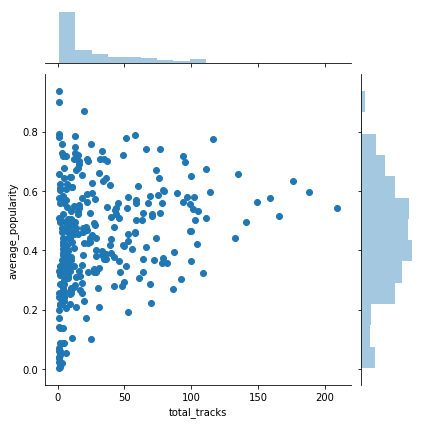

In [500]:
sns.jointplot(data=author_statistics, x='total_tracks', y='average_popularity')

### Корреляции между количеством трэков и популярностью не выявлено.
### Список самых популярных авторов не совпадает со списком самых "плодовитых". Многие популярные авторы имеют менее 10-ти трэков.
### Оценим "важность" авторства для популярности трэка с помощью модели.

In [506]:
scaled_data = pd.get_dummies(processed_data, columns=['author'], drop_first=True)
scaled_data

,bpm,duration,popularity,tags_ 'Atmospheric',tags_ 'Bold',tags_ 'Bouncy',tags_ 'Breezy',tags_ 'Bright',tags_ 'Building',tags_ 'Calm',...,author_Yan Perchuk,author_Yann Monnet,author_Young Presidents,author_Youth Faire,author_Zac Nelson,author_Zach Nicita,author_Zack Hexum,author_Zane Dickinson,author_Zenith Productions,author_Zeonium
0,90,160.0,1.0000,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
1,115,133.0,0.9999,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
2,97,185.0,0.9998,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
3,105,150.0,0.9997,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
4,72,133.0,0.9996,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
5,80,138.0,0.9995,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
6,89,151.0,0.9994,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
7,118,142.0,0.9993,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
8,125,182.0,0.9992,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
9,125,148.0,0.9991,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0


In [513]:
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split

In [510]:
scaler = RobustScaler()
raw_scaled_data = pd.DataFrame(data=scaler.fit_transform(scaled_data), columns=scaled_data.columns)

In [511]:
scaled_data[['bpm', 'duration', 'popularity']] = raw_scaled_data[['bpm', 'duration', 'popularity']]
scaled_data

,bpm,duration,popularity,tags_ 'Atmospheric',tags_ 'Bold',tags_ 'Bouncy',tags_ 'Breezy',tags_ 'Bright',tags_ 'Building',tags_ 'Calm',...,author_Yan Perchuk,author_Yann Monnet,author_Young Presidents,author_Youth Faire,author_Zac Nelson,author_Zach Nicita,author_Zack Hexum,author_Zane Dickinson,author_Zenith Productions,author_Zeonium
0,-0.757576,0.2500,0.996410,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
1,0.000000,-1.4375,0.996210,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
2,-0.545455,1.8125,0.996011,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
3,-0.303030,-0.3750,0.995811,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
4,-1.303030,-1.4375,0.995612,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
5,-1.060606,-1.1250,0.995412,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
6,-0.787879,-0.3125,0.995213,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
7,0.090909,-0.8750,0.995013,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
8,0.303030,1.6250,0.994814,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
9,0.303030,-0.5000,0.994615,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0


In [524]:
scaled_data.isnull().sum()

bpm                                         0
duration                                    2
popularity                                  0
tags_ 'Atmospheric'                         0
tags_ 'Bold'                                0
tags_ 'Bouncy'                              0
tags_ 'Breezy'                              0
tags_ 'Bright'                              0
tags_ 'Building'                            0
tags_ 'Calm'                                0
tags_ 'Carefree'                            0
tags_ 'Celebration'                         0
tags_ 'Celebratory'                         0
tags_ 'Cheerful'                            0
tags_ 'Chic'                                0
tags_ 'Children'                            0
tags_ 'Chill'                               0
tags_ 'Comforting'                          0
tags_ 'Confident'                           0
tags_ 'Contemplative'                       0
tags_ 'Content'                             0
tags_ 'Cool'                      

### Обнаружены пропущенные значения. Заменим их медианами

In [527]:
scaled_data = scaled_data.fillna(scaled_data.median())

In [528]:
train_data, test_data = train_test_split(scaled_data, test_size = 0.3)

In [535]:
y_train = train_data.popularity
y_test = test_data.popularity 

X_train = train_data.drop('popularity', axis=1)
X_test = test_data.drop('popularity', axis=1)

In [572]:
from sklearn import metrics

def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def print_metrics(y_test,y_pred):
    print('MAE:', metrics.mean_absolute_error(np.exp(y_test), np.exp(y_pred)))
    print('RMSE:', np.sqrt(metrics.mean_squared_error(np.exp(y_test), np.exp(y_pred))))
    print('R2:',  metrics.r2_score(y_test, y_pred))
    print('MAPE:', mean_absolute_percentage_error(y_test, y_pred))
    pass

In [582]:
from sklearn.ensemble import RandomForestRegressor

In [589]:
forest_model = RandomForestRegressor(max_depth=2, random_state=0,
                                     n_estimators=100)
forest_model.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=2,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=100,
                      n_jobs=None, oob_score=False, random_state=0, verbose=0,
                      warm_start=False)

In [590]:
y_pred_forest = forest_model.predict(X_test)

In [591]:
print_metrics(y_test,y_pred_forest)

MAE: 0.5168037531496519
RMSE: 0.649811580707723
R2: 0.04292506343384017
MAPE: 122.23448888198878


### Средняя относительная ошибка (MAPE) более 100%. Модель не работает!

In [594]:
from sklearn.linear_model import LinearRegression, LassoCV

In [537]:
lasso_cv_model = LassoCV(cv=5)

In [569]:
lasso_cv_model.fit(X_train, y_train)
y_pred_lasso_cv = lasso_cv_model.predict(X_test)

In [573]:
print_metrics(y_test,y_pred_lasso_cv)

MAE: 0.43572820686131797
RMSE: 0.5557421869257048
R2: 0.28790847293492383
MAPE: 187.0115023999649


### Средняя относительная ошибка ещё больше. Модель также не работает. Попробуем полиномиальную регрессию.

In [597]:
from sklearn.preprocessing import PolynomialFeatures
poly_reg = PolynomialFeatures(degree=2)
X_poly_train = poly_reg.fit_transform(X_train)

In [598]:
pol_reg = RandomForestRegressor(max_depth=2, random_state=0, n_estimators=100)
pol_reg.fit(X_poly_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=2,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=100,
                      n_jobs=None, oob_score=False, random_state=0, verbose=0,
                      warm_start=False)

In [600]:
X_poly_test = poly_reg.transform(X_test)
y_pred_poly = pol_reg.predict(X_poly_test)

In [601]:
print_metrics(y_test,y_pred_poly)

MAE: 0.5171263680288193
RMSE: 0.6490466607436184
R2: 0.045537653867259276
MAPE: 120.66739158635139


### Результат также неудовлетворительный. Модель не работает.

## <font color=red> Возможные выводы:</font>
## <font color=red> 1. Описание трэков с помощью различных тэгов (настроение, использованные интсрументы и т.п.) не достаточно для построения модели предсказания популярности трэков </font>
## <font color=red> 2. Для построения такой модели требуется более сложная модель, чем линейная/полиномиальная регрессия, или случайный лес</font>